In [1]:
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def dilser(low=0.001, limit=100., dilfactor=2.):
    '''returns a numpy array dilution series from low to limit'''
    #replace this with a generator/iterator someday
    a = [low]
    while a[-1] <= limit:
        a.append(a[len(a)-1]*dilfactor)
    return np.array(a)

In [3]:
def binterval(k):
    '''takes apparent binding constent and builds lig series around it (2 log intervals on either end)'''
    low = (1/k)/100
    limit = (1/k)*100
    return dilser(low=low,limit=limit)

In [4]:
def lognuniform(low=0, high=1, size=None, base=np.exp(1)):
    return np.power(base, np.random.uniform(low, high, size))

In [5]:
def guessgen(length,lowmag=-3,himag=3,base=10):
    return tuple(lognuniform(low=lowmag,high=himag,base=base) for i in range(length))

In [6]:
def colroots(data,ligs): 
    holder = []
    for i in range(len(ligs)):
        temp = data[:,i]
        roots,counts = np.unique(temp,return_counts=True)
        posroots = roots[roots>0]
        poscounts = counts[roots>0]
        clctd = np.stack((posroots,poscounts),axis=1)
        clctd = clctd[(-1*clctd[:,1]).argsort()]
        holder.append(clctd[:3]) #only take top 3 (or fewer) guesses
    return holder

In [7]:
def wymsol(var,parm,rtot,ltot):
    
    k11 = parm[0]
    k21 = parm[1]
    k22 = parm[2]
    l20 = parm[3]
    
    (L, M, MM, ML, MML, MMLL) = var
    
    eq1 = (M + 2*MM + ML + 2*MML + 2*MMLL) - rtot
    eq2 = (L + ML + MML + 2*MMLL) - ltot
    eq3 = (l20 * M*M) - MM
    eq4 = (k11 * L * M) - ML
    eq5 = (l20 * k21 * M*M * L) - MML
    eq6 = (k22 * L * MML) - MMLL
    
    return np.array([eq1,eq2,eq3,eq4,eq5,eq6])

In [35]:
rtotwym = np.array([1e-5,1e-4,1e-3,1e-2,1e-1])
parmwym = np.array([20.,2.,0.5,5000.])
wymguesses = [guessgen(6) for i in range(50)]

In [36]:
bintvar = parmwym[0]/(parmwym[1]*parmwym[2])
lig_concs = binterval(bintvar)

In [37]:
%%time
wymar = np.array([[[optimize.root(wymsol,i,args=(parmwym,q,j),method='lm',options={'ftol':1e-14,'gtol':1e-14,'xtol':1e-14}).x for j in lig_concs] for i in wymguesses] for q in rtotwym])

CPU times: user 10.5 s, sys: 31.7 ms, total: 10.6 s
Wall time: 10.6 s


In [38]:
#original 
rootbag_wym = [[colroots(wymar[k,:,:,j],lig_concs) for j in range(6)] for  k in range(5)]

In [39]:
allroots = np.array([[np.array([rootbag_wym[q][j][i][0][0] for i in range(len(lig_concs))]) for j in range(6)] for q in range(5)])

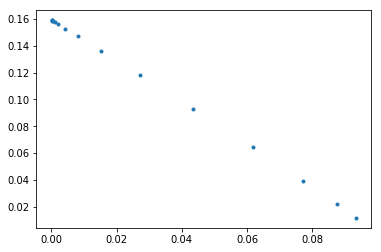

In [51]:
for i in range(4,5):
    bnd = allroots[i][3] + allroots[i][4] + 2*allroots[i][5]
    fre = allroots[i][0]
    plt.plot(bnd,(bnd/fre),'.')

Text(0.5,0.98,'poop')

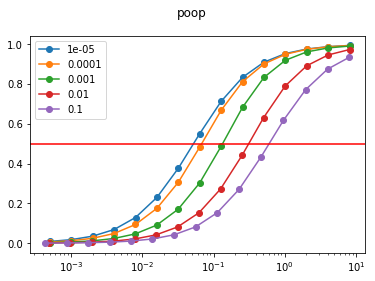

In [43]:
for i in range(5):
    bnd = allroots[i][3] + allroots[i][4] + 2*allroots[i][5]
    fre = allroots[i][0]
    rtot = rtotwym[i]
    plt.semilogx(fre,(bnd/rtot),'o-')
plt.legend(rtotwym)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.suptitle('poop')

In [48]:
rebound = bnd*rtot

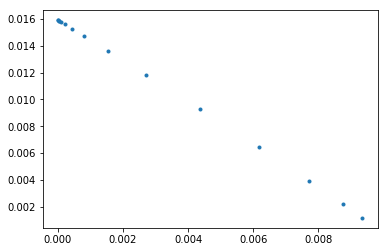

In [50]:
plt.plot(rebound,rebound/fre,'.')